t-SNE

In [1]:
import numpy as np
import pandas as pd
import os
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
def format_data(path, path2, label, label2):
    files = os.listdir(path) 
    paths = [r"{}\{}".format(path,i) for i in files]
    
    files = os.listdir(path2) 
    paths2 = [r"{}\{}".format(path2,i) for i in files]
    
    df = pd.DataFrame(paths, columns=['Path'])
    df['Label'] = label
    
    df2 = pd.DataFrame(paths2, columns=['Path'])
    df2['Label'] = label2
    
    return df.append(df2).reset_index(drop=True)

In [18]:
val_cat_images_directory =  r"E:\Data\DogAndCats\cats_and_dogs_filtered\validation\cats"
val_dog_images_directory =  r"E:\Data\DogAndCats\cats_and_dogs_filtered\validation\dogs"

val_df = format_data(path=val_cat_images_directory,
                       path2=val_dog_images_directory,
                       label=0,
                       label2=1)

In [10]:
val_df.head()

,Path,Label
0,E:\Data\DogAndCats\cats_and_dogs_filtered\vali...,cat
1,E:\Data\DogAndCats\cats_and_dogs_filtered\vali...,cat
2,E:\Data\DogAndCats\cats_and_dogs_filtered\vali...,cat
3,E:\Data\DogAndCats\cats_and_dogs_filtered\vali...,cat
4,E:\Data\DogAndCats\cats_and_dogs_filtered\vali...,cat


In [11]:
import cv2

In [12]:
np.array(imread(val_df['Path'][0])).shape

(499, 459, 3)

In [13]:
x_val = [ cv2.resize(imread(i), (150,150)) for i in val_df['Path']]
x_val = np.array(x_val)

In [14]:
x_val = x_val.reshape(1000,(150*150*3))

In [20]:
def data_scatter(vecs, labels):
    label = ['cat','dog']
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, str(label[idx]), fontsize=24)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

In [16]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

dogs_and_cats_tsne = TSNE(random_state=42).fit_transform(x_val)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 131.70824313163757 seconds


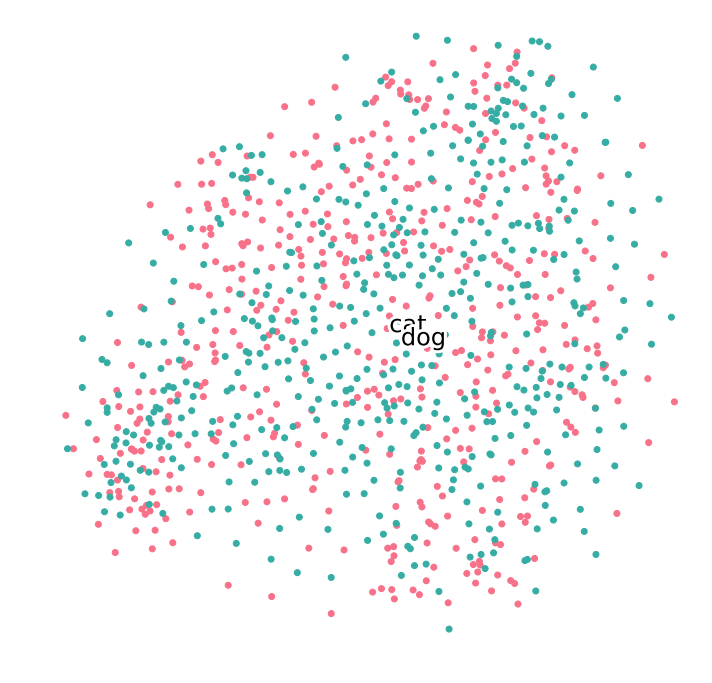

In [21]:
# visualize t-SNE output
data_scatter(dogs_and_cats_tsne, val_df['Label'])

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

IMG_SHAPE = (150, 150, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,)

x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
predictions = layers.Dense(2, activation='sigmoid')(x)

model = models.Model(base_model.input, predictions)
last_conv_layer = model.get_layer('block5_conv4')

model.load_weights(r"C:\Users\ken\Desktop\OneDrive\OneDrive - Knights - University of Central Florida\UCF Spring 2019\Machine Learning\TransferLearning\Weights\VGG19_CAT_AND_DOGS_BEST.h5py")

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [24]:
layer = model.get_layer('dense')
layer_output = layer.output

In [25]:
activation_model = models.Model(model.input, layer_output)

In [26]:
x_val = x_val.reshape(1000,150,150,3)

In [27]:
activations = activation_model.predict(x_val)

In [28]:
activations.shape

(1000, 256)

In [29]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

dogs_and_cats_tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 9.728679895401001 seconds


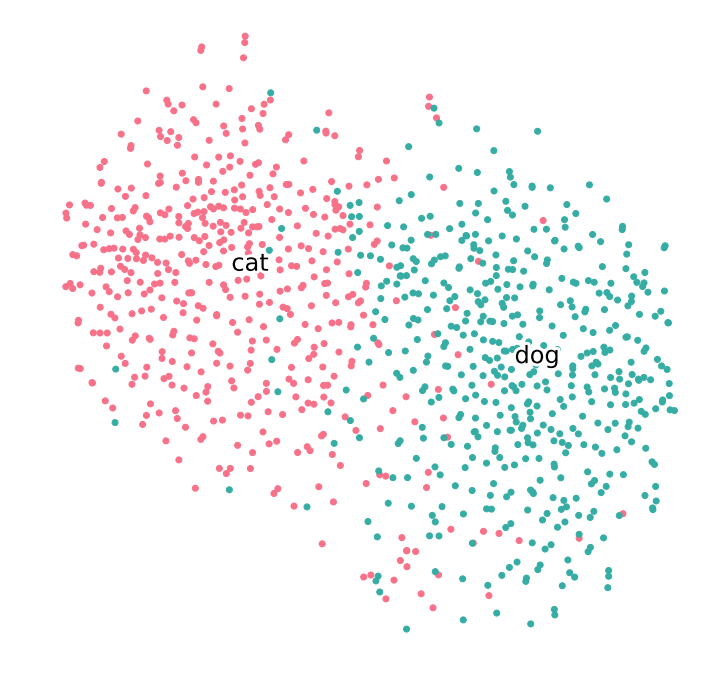

In [30]:
data_scatter(dogs_and_cats_tsne, val_df['Label'])